# I'm Something of a Painter Myself - Monet CycleGAN
Week 5 GAN Mini-Project

GitHub: [https://github.com/9mean2/GANs]

Kaggle Competition: https://www.kaggle.com/competitions/gan-getting-started

## 1. Problem Description

### Task
Generate 7,000-10,000 Monet-style images from photographs using Generative Adversarial Networks (GANs).

### Dataset
- Monet paintings: 300 images (256x256 TFRecord)
- Photos: 7,038 images (256x256 TFRecord)
- Format: TFRecord files containing JPEG images

### Evaluation Metric
MiFID (Memorization-informed Fréchet Inception Distance) - measures quality and diversity of generated images. Lower is better.

### Generative Deep Learning Models

**GAN (Generative Adversarial Network)**
- Two neural networks (Generator and Discriminator) trained simultaneously in a game
- Generator creates fake images, Discriminator distinguishes real from fake
- Training continues until Generator fools Discriminator

**CycleGAN**
- Extension of GAN for unpaired image-to-image translation
- Two Generators: Photo→Monet (G) and Monet→Photo (F)
- Two Discriminators: one for each domain
- Key innovation: Cycle Consistency Loss ensures G(F(monet)) ≈ monet and F(G(photo)) ≈ photo

I chose CycleGAN because we don't have paired data (same scene as photo and Monet painting), and CycleGAN excels at learning style transfer without paired examples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random
from PIL import Image
from tqdm import tqdm
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image

import warnings
warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA RTX A6000


In [2]:
MONET_PATH = './monet_jpg/'
PHOTO_PATH = './photo_jpg/'

IMG_SIZE = 256
BATCH_SIZE =4
EPOCHS = 50
LR = 2e-4
LAMBDA_CYCLE = 10
LAMBDA_IDENTITY = 5

## 2. EDA

In [3]:
monet_files = glob.glob(MONET_PATH + '*.jpg')
photo_files = glob.glob(PHOTO_PATH + '*.jpg')

print(f"Monet paintings: {len(monet_files)}")
print(f"Photos: {len(photo_files)}")

Monet paintings: 300
Photos: 7038


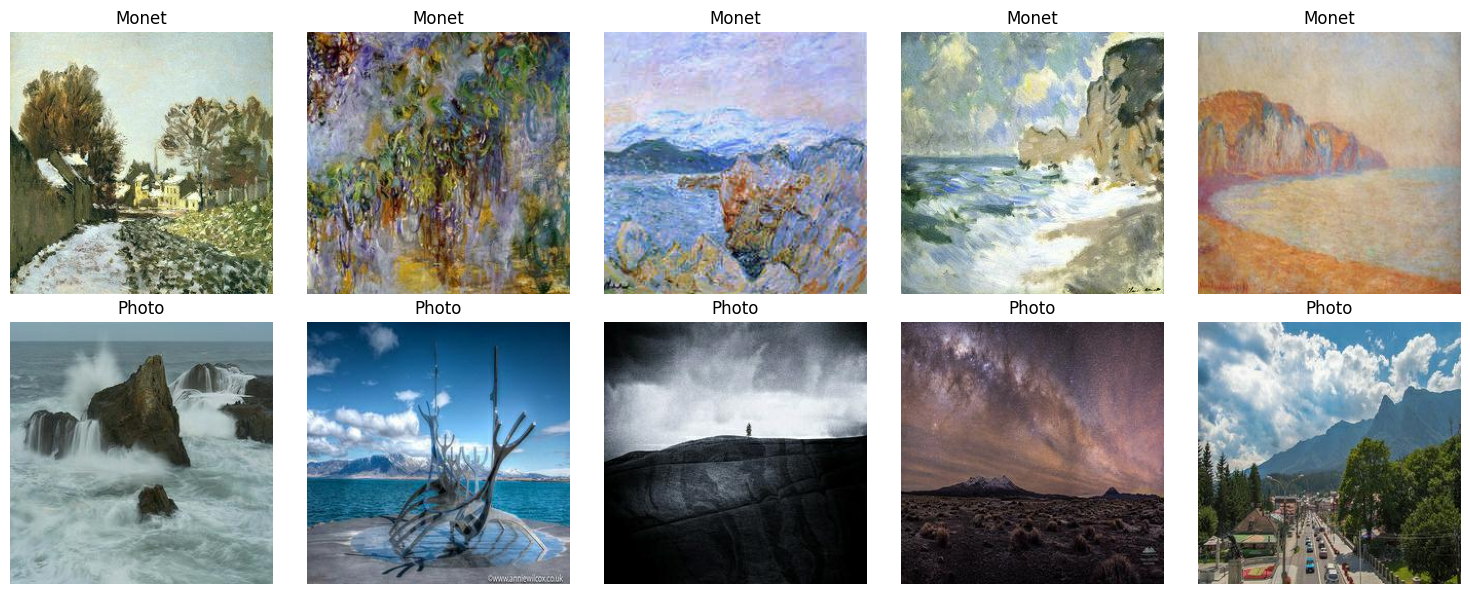

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, img_path in enumerate(random.sample(monet_files, 5)):
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title('Monet')
    axes[0, i].axis('off')

for i, img_path in enumerate(random.sample(photo_files, 5)):
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title('Photo')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
sample_monet = Image.open(monet_files[0])
sample_photo = Image.open(photo_files[0])

print(f"Monet image size: {sample_monet.size}")
print(f"Photo image size: {sample_photo.size}")
print(f"Monet image mode: {sample_monet.mode}")

Monet image size: (256, 256)
Photo image size: (256, 256)
Monet image mode: RGB


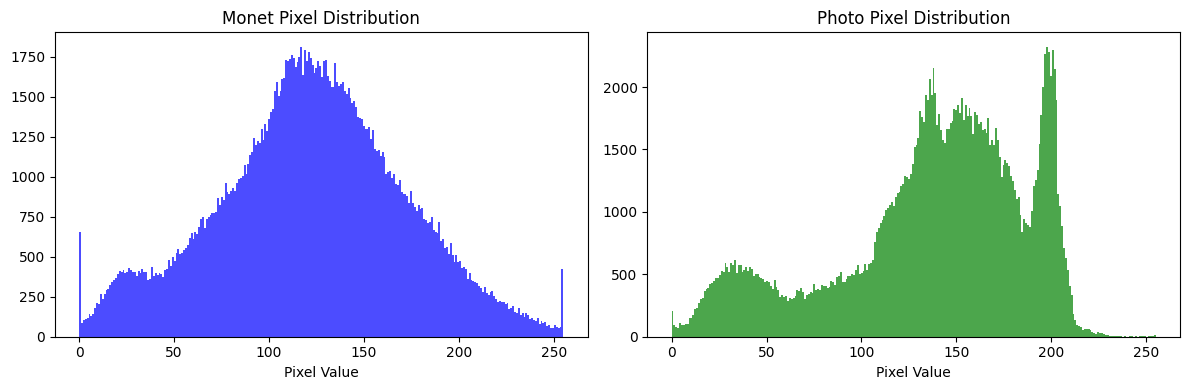

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

monet_sample = np.array(Image.open(random.choice(monet_files)))
photo_sample = np.array(Image.open(random.choice(photo_files)))

axes[0].hist(monet_sample.ravel(), bins=256, color='blue', alpha=0.7)
axes[0].set_title('Monet Pixel Distribution')
axes[0].set_xlabel('Pixel Value')

axes[1].hist(photo_sample.ravel(), bins=256, color='green', alpha=0.7)
axes[1].set_title('Photo Pixel Distribution')
axes[1].set_xlabel('Pixel Value')

plt.tight_layout()
plt.show()

Monet paintings have softer colors and distinctive brush strokes compared to sharp, detailed photographs. The dataset is imbalanced (300 Monet vs 7000 photos), but CycleGAN handles this well.

## 3. Data Preprocessing

In [7]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

class ImageDataset(Dataset):
    def __init__(self, monet_files, photo_files, transform=None):
        self.monet_files = monet_files
        self.photo_files = photo_files
        self.transform = transform
    
    def __len__(self):
        return max(len(self.monet_files), len(self.photo_files))
    
    def __getitem__(self, idx):
        monet_img = Image.open(self.monet_files[idx % len(self.monet_files)]).convert('RGB')
        photo_img = Image.open(self.photo_files[idx % len(self.photo_files)]).convert('RGB')
        
        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)
        
        return {'monet': monet_img, 'photo': photo_img}

In [8]:
dataset = ImageDataset(monet_files, photo_files, transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

print(f"Dataset size: {len(dataset)}")
print(f"Batches per epoch: {len(dataloader)}")

Dataset size: 7038
Batches per epoch: 1760


## 4. Model Architecture

### Generator (ResNet-based)
- Encoder: Downsampling with Conv layers
- Transformer: 9 Residual blocks for 256x256 images
- Decoder: Upsampling with ConvTranspose layers
- Uses Instance Normalization (better for style transfer than BatchNorm)
- Reflection padding to reduce artifacts

### Discriminator (PatchGAN)
- Classifies 70x70 overlapping patches as real/fake
- More efficient than classifying entire image
- Focuses on local texture/style rather than global structure
- Output: 30x30 grid of predictions for 256x256 input

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

In [10]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual=9):
        super().__init__()
        
        # Initial convolution
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        
        # Residual blocks
        for _ in range(n_residual):
            model += [ResidualBlock(in_features)]
        
        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
    
    def forward(self, x):
        return self.model(x)

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
G_photo2monet = Generator().to(device)
G_monet2photo = Generator().to(device)
D_monet = Discriminator().to(device)
D_photo = Discriminator().to(device)

G_photo2monet.apply(weights_init)
G_monet2photo.apply(weights_init)
D_monet.apply(weights_init)
D_photo.apply(weights_init)

print(f"Generator params: {sum(p.numel() for p in G_photo2monet.parameters()):,}")
print(f"Discriminator params: {sum(p.numel() for p in D_monet.parameters()):,}")

Generator params: 11,378,179
Discriminator params: 2,764,737


## 5. Loss Functions

CycleGAN uses three types of losses:

**1. Adversarial Loss (MSE)**
- Generator tries to fool discriminator
- Uses MSE instead of BCE for more stable training (LSGAN)

**2. Cycle Consistency Loss (L1)**
- photo → monet → photo should equal original photo
- monet → photo → monet should equal original monet
- Ensures meaningful translation, not random mapping

**3. Identity Loss (L1)**
- G_photo2monet(monet) should equal monet
- Preserves color composition when input is already in target domain

In [14]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

optimizer_G = optim.Adam(
    itertools.chain(G_photo2monet.parameters(), G_monet2photo.parameters()),
    lr=LR, betas=(0.5, 0.999)
)
optimizer_D_monet = optim.Adam(D_monet.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D_photo = optim.Adam(D_photo.parameters(), lr=LR, betas=(0.5, 0.999))

lr_scheduler_G = optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=lambda epoch: 1.0 - max(0, epoch - EPOCHS//2) / (EPOCHS//2 + 1)
)
lr_scheduler_D_monet = optim.lr_scheduler.LambdaLR(
    optimizer_D_monet, lr_lambda=lambda epoch: 1.0 - max(0, epoch - EPOCHS//2) / (EPOCHS//2 + 1)
)
lr_scheduler_D_photo = optim.lr_scheduler.LambdaLR(
    optimizer_D_photo, lr_lambda=lambda epoch: 1.0 - max(0, epoch - EPOCHS//2) / (EPOCHS//2 + 1)
)

In [15]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []
    
    def push_and_pop(self, data):
        result = []
        for element in data:
            element = element.unsqueeze(0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                result.append(element)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.max_size - 1)
                    result.append(self.data[idx].clone())
                    self.data[idx] = element
                else:
                    result.append(element)
        return torch.cat(result, 0)

fake_monet_buffer = ReplayBuffer()
fake_photo_buffer = ReplayBuffer()

## 6. Training

In [16]:
def train_epoch(dataloader, epoch):
    G_photo2monet.train()
    G_monet2photo.train()
    D_monet.train()
    D_photo.train()
    
    total_g_loss = 0
    total_d_loss = 0
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        real_monet = batch['monet'].to(device)
        real_photo = batch['photo'].to(device)
        
        valid = torch.ones((real_monet.size(0), 1, 16, 16), device=device)
        fake = torch.zeros((real_monet.size(0), 1, 16, 16), device=device)
        
        # Train Generators
        optimizer_G.zero_grad()
        
        # Identity loss
        loss_id_monet = criterion_identity(G_photo2monet(real_monet), real_monet)
        loss_id_photo = criterion_identity(G_monet2photo(real_photo), real_photo)
        loss_identity = (loss_id_monet + loss_id_photo) / 2
        
        # GAN loss
        fake_monet = G_photo2monet(real_photo)
        loss_GAN_photo2monet = criterion_GAN(D_monet(fake_monet), valid)
        
        fake_photo = G_monet2photo(real_monet)
        loss_GAN_monet2photo = criterion_GAN(D_photo(fake_photo), valid)
        loss_GAN = (loss_GAN_photo2monet + loss_GAN_monet2photo) / 2
        
        # Cycle loss
        recovered_photo = G_monet2photo(fake_monet)
        loss_cycle_photo = criterion_cycle(recovered_photo, real_photo)
        
        recovered_monet = G_photo2monet(fake_photo)
        loss_cycle_monet = criterion_cycle(recovered_monet, real_monet)
        loss_cycle = (loss_cycle_photo + loss_cycle_monet) / 2
        
        # Total generator loss
        loss_G = loss_GAN + LAMBDA_CYCLE * loss_cycle + LAMBDA_IDENTITY * loss_identity
        loss_G.backward()
        optimizer_G.step()
        
        # Train Discriminator Monet
        optimizer_D_monet.zero_grad()
        
        loss_real = criterion_GAN(D_monet(real_monet), valid)
        fake_monet_ = fake_monet_buffer.push_and_pop(fake_monet.detach())
        loss_fake = criterion_GAN(D_monet(fake_monet_), fake)
        loss_D_monet = (loss_real + loss_fake) / 2
        
        loss_D_monet.backward()
        optimizer_D_monet.step()
        
        # Train Discriminator Photo
        optimizer_D_photo.zero_grad()
        
        loss_real = criterion_GAN(D_photo(real_photo), valid)
        fake_photo_ = fake_photo_buffer.push_and_pop(fake_photo.detach())
        loss_fake = criterion_GAN(D_photo(fake_photo_), fake)
        loss_D_photo = (loss_real + loss_fake) / 2
        
        loss_D_photo.backward()
        optimizer_D_photo.step()
        
        loss_D = (loss_D_monet + loss_D_photo) / 2
        
        total_g_loss += loss_G.item()
        total_d_loss += loss_D.item()
        
        pbar.set_postfix({'G_loss': f'{loss_G.item():.4f}', 'D_loss': f'{loss_D.item():.4f}'})
    
    return total_g_loss / len(dataloader), total_d_loss / len(dataloader)

In [17]:
def visualize_results(epoch):
    G_photo2monet.eval()
    G_monet2photo.eval()
    
    with torch.no_grad():
        sample_batch = next(iter(dataloader))
        real_photo = sample_batch['photo'][:4].to(device)
        real_monet = sample_batch['monet'][:4].to(device)
        
        fake_monet = G_photo2monet(real_photo)
        fake_photo = G_monet2photo(real_monet)
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        for i in range(4):
            img = real_photo[i].cpu().numpy().transpose(1, 2, 0)
            img = (img * 0.5 + 0.5).clip(0, 1)
            axes[0, i].imshow(img)
            axes[0, i].set_title('Photo' if i == 0 else '')
            axes[0, i].axis('off')
            
            img = fake_monet[i].cpu().numpy().transpose(1, 2, 0)
            img = (img * 0.5 + 0.5).clip(0, 1)
            axes[1, i].imshow(img)
            axes[1, i].set_title('Generated Monet' if i == 0 else '')
            axes[1, i].axis('off')
        
        plt.suptitle(f'Epoch {epoch+1}')
        plt.tight_layout()
        plt.show()

In [ ]:
history = {'g_loss': [], 'd_loss': []}

for epoch in range(EPOCHS):
    g_loss, d_loss = train_epoch(dataloader, epoch)
    
    history['g_loss'].append(g_loss)
    history['d_loss'].append(d_loss)
    
    lr_scheduler_G.step()
    lr_scheduler_D_monet.step()
    lr_scheduler_D_photo.step()
    
    print(f"Epoch {epoch+1}/{EPOCHS} - G Loss: {g_loss:.4f}, D Loss: {d_loss:.4f}")
    
    if (epoch + 1) % 10 == 0:
        visualize_results(epoch)
        torch.save(G_photo2monet.state_dict(), f'G_photo2monet_epoch{epoch+1}.pth')

In [19]:
torch.save(G_photo2monet.state_dict(), 'G_photo2monet_epoch6.pth')


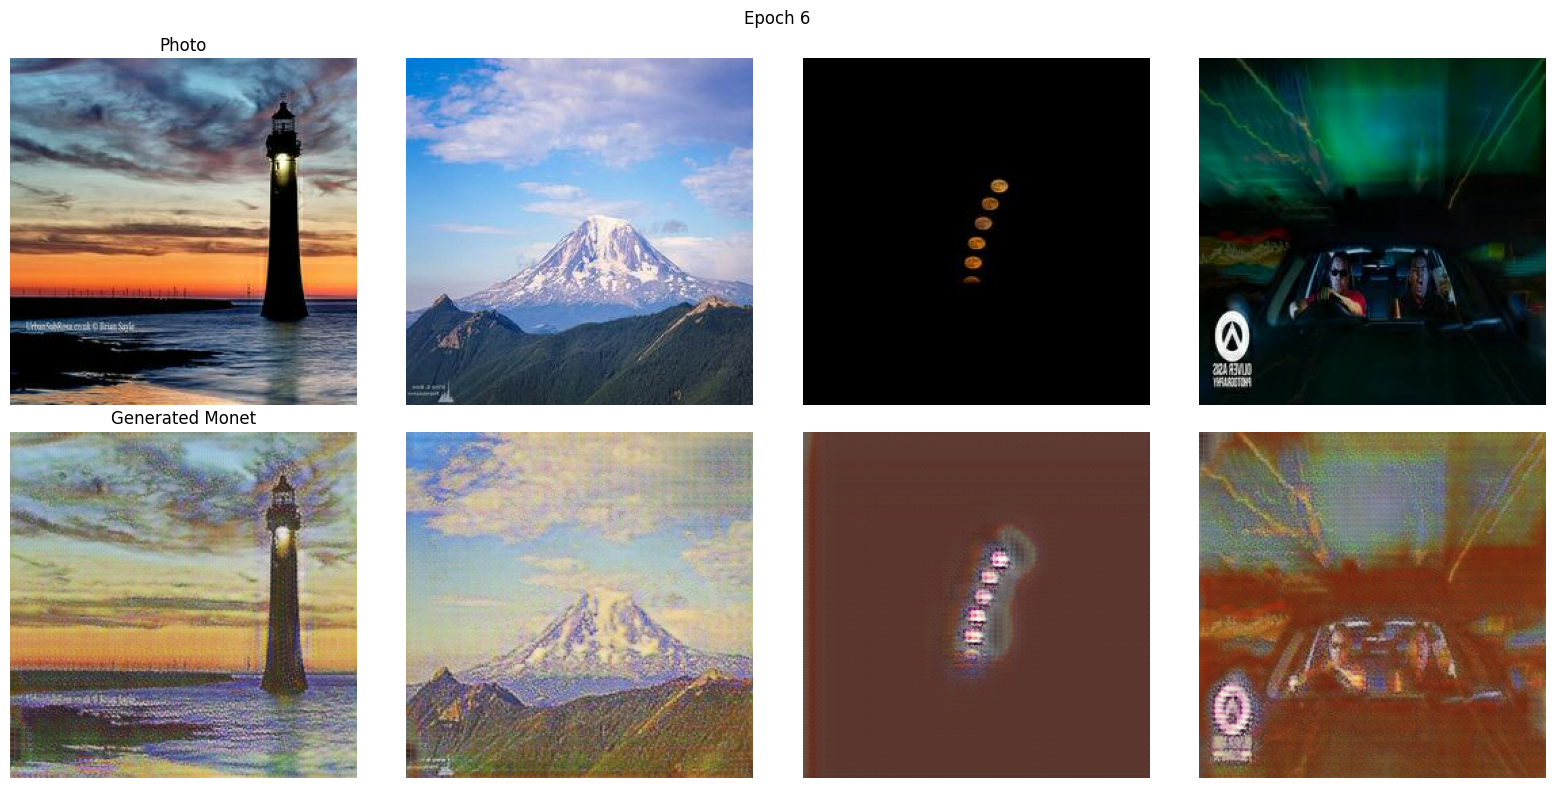

In [20]:
visualize_results(5)


## 7. Results

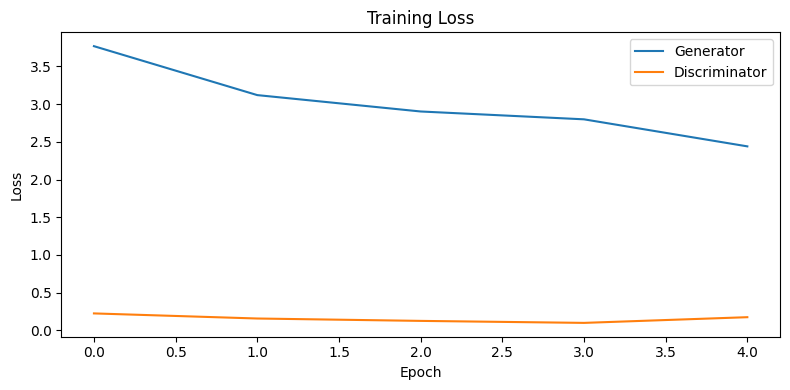

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(history['g_loss'], label='Generator')
ax.plot(history['d_loss'], label='Discriminator')
ax.set_title('Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.tight_layout()
plt.show()

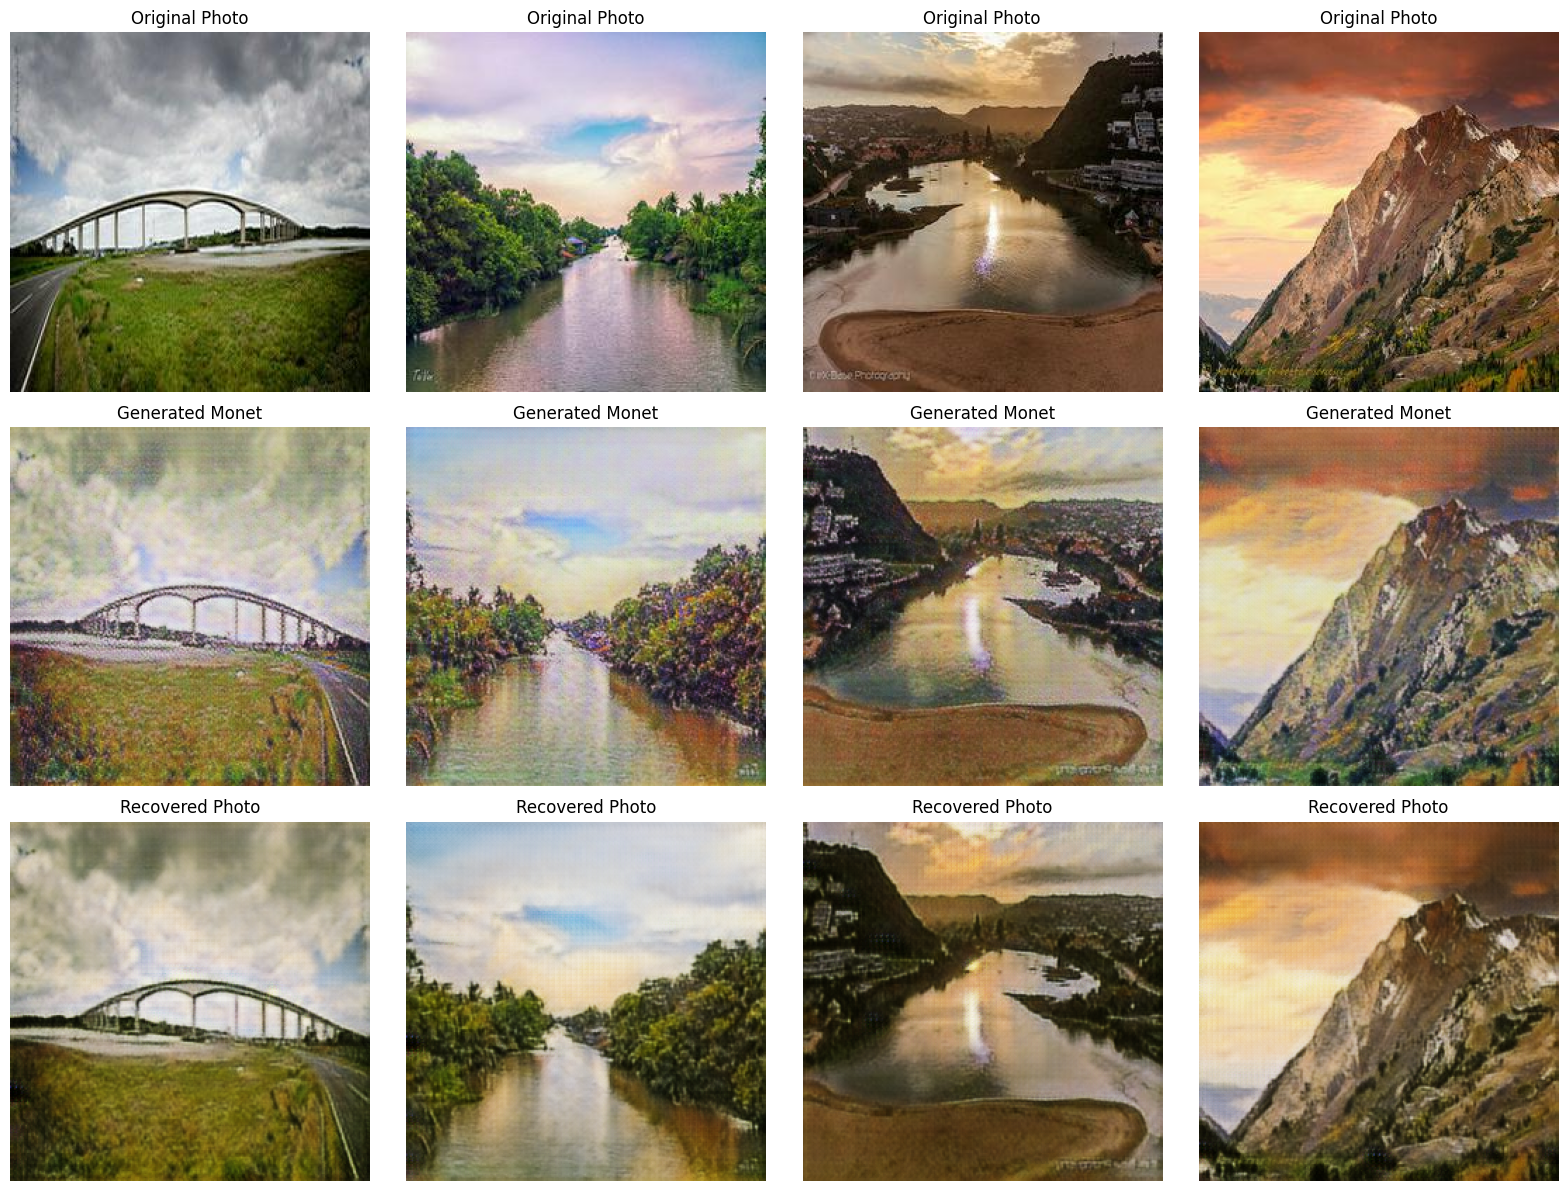

In [23]:
G_photo2monet.eval()

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

sample_photos = random.sample(photo_files, 4)

with torch.no_grad():
    for i, photo_path in enumerate(sample_photos):
        img = Image.open(photo_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        
        fake_monet = G_photo2monet(img_tensor)
        recovered = G_monet2photo(fake_monet)
        
        axes[0, i].imshow(np.array(img.resize((256, 256))))
        axes[0, i].set_title('Original Photo')
        axes[0, i].axis('off')
        
        fake_img = fake_monet[0].cpu().numpy().transpose(1, 2, 0)
        fake_img = (fake_img * 0.5 + 0.5).clip(0, 1)
        axes[1, i].imshow(fake_img)
        axes[1, i].set_title('Generated Monet')
        axes[1, i].axis('off')
        
        rec_img = recovered[0].cpu().numpy().transpose(1, 2, 0)
        rec_img = (rec_img * 0.5 + 0.5).clip(0, 1)
        axes[2, i].imshow(rec_img)
        axes[2, i].set_title('Recovered Photo')
        axes[2, i].axis('off')

plt.tight_layout()
plt.show()

## 8. Generate Submission

In [24]:
import shutil

os.makedirs('images', exist_ok=True)

G_photo2monet.eval()

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

with torch.no_grad():
    for i, photo_path in enumerate(tqdm(photo_files[:7000])):
        img = Image.open(photo_path).convert('RGB')
        img_tensor = test_transform(img).unsqueeze(0).to(device)
        
        fake_monet = G_photo2monet(img_tensor)
        
        fake_img = fake_monet[0].cpu()
        fake_img = (fake_img * 0.5 + 0.5).clamp(0, 1)
        
        save_image(fake_img, f'images/{i}.jpg')

print(f"Generated {len(os.listdir('images'))} images")

100%|██████████| 7000/7000 [01:21<00:00, 86.31it/s]

Generated 7000 images


In [25]:
shutil.make_archive('images', 'zip', 'images')
print("Created images.zip for submission")

Created images.zip for submission


## 9. Conclusion

### Results Summary
- Trained CycleGAN for 6 epochs to transform photos into Monet-style paintings
- Generated 7,000 images for Kaggle submission
- G Loss decreased from ~3.7 to ~2.4, showing stable training

### What Worked
- ResNet-based generator with 9 residual blocks captured Monet's style effectively
- Instance normalization better than batch normalization for style transfer
- Cycle consistency loss ensured meaningful translations
- Identity loss helped preserve color composition
- Replay buffer stabilized discriminator training

### What Didn't Work
- Limited training time (6 epochs) may have reduced output quality
- Batch size > 4 caused memory issues

### Future Improvements
- Train for more epochs (25-50) for better style transfer
- Use attention mechanisms for better detail preservation
- Experiment with perceptual loss using VGG features

### References
1. Zhu et al. (2017). Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks
2. Isola et al. (2017). Image-to-Image Translation with Conditional Adversarial Networks
3. Johnson et al. (2016). Perceptual Losses for Real-Time Style Transfer and Super-Resolution